# Decision Tree Models for Cell Fate Choice

Notebook provided in support of the "Decision Trees for Cell Fate Choice" manuscript written by Ivan A. Croydon Veleslavov and Professor Michael P.H. Stumpf. This notebook covers training decision tree models in Julia from single-cell data, assessing their predictive performance on witheld samples as well as providing several model visualisations and extensions.

* [Learning decision tree models](#Learning-decision-tree-models)
* [Exploring model structure](#Exploring-model-structure)
* [Evaluating model performance](#Evaluating-model-performance)
* [Designing minimal perturbations for sample reclassification](#Minimal-perturbations-for-sample-reclassification)
* [Resolving embryogenesis in Xenopus tropicalis with scaffolded trees](#Resolving-embryogenesis-in-Xenopus-tropicalis)

### Package requirements

In [1]:
using CSV, DataFrames, DecisionTree, Distributions, Random, StatsPlots

In [2]:
include("CellFateDecisionTrees.jl")

Main.CellFateDecisionTrees

### Reading in the data

In [3]:
# Read in the murine gene expression and sample labels
mur_df = CSV.read("../data/murine/murine_expression.csv");
mur_features = deepcopy(convert(Array, mur_df))

# Read in the associated annotation data
mur_labels = CSV.read("../data/murine/murine_annotations.csv");

# Add the class labels as a column "Classifcation" to the expression data
mur_df[:Classification] = mur_labels[:Class];

┌ Warning: `convert(::Type{Array}, df::AbstractDataFrame)` is deprecated, use `convert(Matrix, df)` instead.
│   caller = top-level scope at In[3]:3
└ @ Core In[3]:3


### Learning decision tree models

First, we define a Boolean variable to split the data into training and test sets

In [4]:
# Set seed first
Random.seed!(1234)

mur_train = rand(Bernoulli(0.75), nrow(mur_df)) .== 1;
mur_test = map(!, mur_train);

Then we can train a decision tree model on the samples contained in this training data to predict cell class labels (ESC, EPI, NPC) from the gene expression data

In [5]:
mur_model = build_tree(mur_labels[mur_train,1], mur_features[mur_train,:]);

### Exploring model structure

A summary of the learnt model's constituent nodes can be generated using the <code>summarise_tree</code> function.

In [6]:
mur_model_summary = CellFateDecisionTrees.summarise_tree(mur_model, mur_df)

,Node_name,Depth,Node_type,Node_size,Parent_name,Direction,Entropy
,String,Int64,String,Int64,String,String,Float64
1,"Fgf4,1.9",0,Internal,547,Root,na,0.499662
2,"Pou5f1,7.65",1,Internal,267,"Fgf4,1.9",L,0.207404
3,"Klf4,10.94",1,Internal,280,"Fgf4,1.9",R,0.371187
4,"Esrrb,11.83",2,Internal,193,"Pou5f1,7.65",L,0.0486981
5,"Myst3,12.55",2,Internal,74,"Pou5f1,7.65",R,0.333333
6,"Zfp42,13.7",2,Internal,196,"Klf4,10.94",L,0.220749
7,"Fgf5,9.74",2,Internal,84,"Klf4,10.94",R,0.0889217
8,"Fbxo15,15.45",3,Internal,191,"Esrrb,11.83",L,0.0201581
9,EPI,3,External,2,"Esrrb,11.83",R,0.0


We can count the number of internal and external nodes using this model summary

In [7]:
sum(mur_model_summary[:Node_type].=="Internal")

22

Alternatively, we can get a better idea of the model structure using <code>print_tree</code>, here to an optional depth of 4 nodes

In [8]:
print_tree(mur_model, 4)

Feature 22, Threshold 1.90351590275
L-> Feature 67, Threshold 7.652433501500001
    L-> Feature 19, Threshold 11.833967458250001
        L-> Feature 21, Threshold 15.451647809
            L-> NPC : 141/141
            R-> EPI : 1/1
        R-> EPI : 2/2
    R-> Feature 55, Threshold 12.5458981325
        L-> Feature 17, Threshold 9.918942661500001
            L-> 
            R-> EPI : 14/14
        R-> Feature 31, Threshold 11.786733910999999
            L-> NPC : 19/19
            R-> 
R-> Feature 45, Threshold 10.9381773055
    L-> Feature 96, Threshold 13.697564680500001
        L-> Feature 15, Threshold 16.1461143175
            L-> 
            R-> EPI : 96/96
        R-> Feature 32, Threshold 3.051485820500001
            L-> 
            R-> 
    R-> Feature 23, Threshold 9.742399220500001
        L-> ESC : 61/61
        R-> Feature 88, Threshold 13.69297821025
            L-> ESC : 2/2
            R-> EPI : 3/3


We also provide a function <code>sankey_text</code> which generates output text describing a Decision Tree model, writing it to 
destination text file. This saved output can be used to generate a sankey diagram visualisation of the model at http://sankeymatic.com/build/

In [9]:
CellFateDecisionTrees.sankey_text("../supplementary/murine_sankey_output.txt", mur_model, mur_df);

<img src="../figures/Figure3b.png">

The Boolean ruleset learnt by the decision tree model to classify the samples can be expressed verbosely too, and we provide this functionality through the <code>get_rules</code> function

In [10]:
rules = CellFateDecisionTrees.get_rules(mur_model, mur_df)
rules[1]

"If Fgf4 is less than or equal to 1.9 AND if Pou5f1 is less than or equal to 7.65 AND if Esrrb is less than or equal to 11.83 AND if Fbxo15 is less than or equal to 15.45 then sample belongs to class NPC"

### Evaluating model performance
The trained decision tree model can be used to generate predictions for previously unseen data

In [11]:
mur_predictions = apply_tree(mur_model, mur_features[mur_test, :]);

We can compare these predictions against the true labels that were witheld during model training using a confusion matrix. The accuracy of these predictions can be calculated simply as the proportion of labels attributed by the model that match the true hidden labels. Note that class labels for the confusion matrices shown here ordered alphabetically by default (EPI, ESC, NPC)

In [12]:
mur_confusion_matrix = confusion_matrix(mur_predictions, mur_labels[mur_test,1])
mur_confusion_matrix.matrix

3×3 Array{Int64,2}:
 40   1   8
  2  18   0
  5   0  55

In [13]:
mur_confusion_matrix.accuracy

0.875968992248062

We also perform cross-validation to consider how models perform over varied training/test splits

In [14]:
num_folds = 5
prune_purity = 1.0
max_depth = 5

cm_accuracies, cm_5fold = nfoldCV_tree(mur_labels[:,1], mur_features,
 num_folds, prune_purity, max_depth)

MethodError: MethodError: no method matching nfoldCV_tree(::PooledArrays.PooledArray{String,UInt32,1,Array{UInt32,1}}, ::Array{Float64,2}, ::Int64, ::Float64, ::Int64)
Closest candidates are:
  nfoldCV_tree(!Matched::Array{T<:Float64,1}, ::Array{S,2}, ::Integer, ::Float64, ::Integer) where {S, T<:Float64} at /Users/ivanv/.julia/packages/DecisionTree/nfB7O/src/measures.jl:283
  nfoldCV_tree(!Matched::Array{T<:Float64,1}, ::Array{S,2}, ::Integer, ::Float64, ::Integer, !Matched::Integer) where {S, T<:Float64} at /Users/ivanv/.julia/packages/DecisionTree/nfB7O/src/measures.jl:283
  nfoldCV_tree(!Matched::Array{T<:Float64,1}, ::Array{S,2}, ::Integer, ::Float64, ::Integer, !Matched::Integer, !Matched::Integer) where {S, T<:Float64} at /Users/ivanv/.julia/packages/DecisionTree/nfB7O/src/measures.jl:283
  ...

In combination with the ideas explored by n-fold cross-validation, we can directly explore how changes to hyperparemeters affect model training and performance. Here we show the range of model performance at varying tree depths for many random training-test partitions.

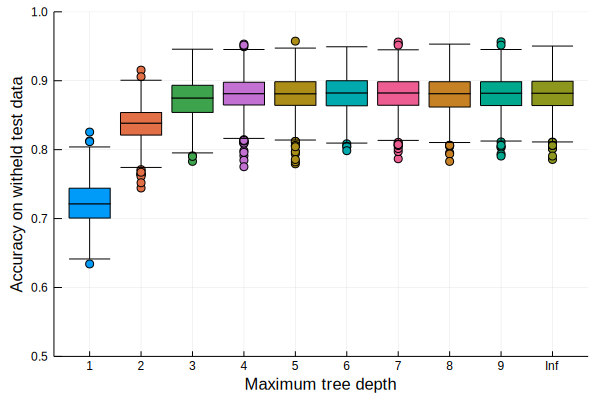

In [15]:
num_trials_per_depth = 1000
tree_depths = [1,2,3,4,5,6,7,8,9,-1]

accuracies = zeros(num_trials_per_depth,length(tree_depths));

for trial in 1:num_trials_per_depth
    
    training_filter = rand(Bernoulli(0.75), nrow(mur_df)) .== 1;
    test_filter = map(!, training_filter);
    
    for (depth_ii, depth_limit) in enumerate(tree_depths)
           
        trained_model = build_tree(mur_labels[training_filter,1], mur_features[training_filter,:], 0, depth_limit);
        mur_predictions = apply_tree(trained_model, mur_features[test_filter, :]);
        trained_model_accuracy = confusion_matrix(mur_predictions, mur_labels[test_filter,1]).accuracy

        accuracies[trial, depth_ii] = trained_model_accuracy
    end
end

series_labels = map(string, tree_depths)
series_labels[series_labels.=="-1"] .= "Inf"

boxplot(accuracies,leg=false, xlabel = "Maximum tree depth", ylabel= "Accuracy on witheld test data", ylim = (0.5,1.0))
xticks!([1:length(tree_depths);], series_labels)

### Minimal perturbations for sample reclassification

First, we pull out a single sample not used in training (here, test sample #10).

In [16]:
sample = mur_features[mur_test,:][10,:];

We can see that the model's initial classification of this sample is ESC, and that in this case the model's prediction agrees with the sample's true (hidden) label

In [17]:
# Model's initial classification of the sample returns ESC
og_label = apply_tree(mur_model, sample)

"ESC"

In [18]:
# Compare to hidden (real) label
og_label == mur_df[:Classification][10]

true

We then stipulate a target label that we wish the sample to be reclassified as

In [19]:
target_label = "EPI"

"EPI"

Now given the learnt decision tree model, the sample and the target label for that sample we can generate the minimal sets of perturbations which would cause the model to reclassify the sample appropriately.

In [20]:
perturbations = CellFateDecisionTrees.generate_sample_mutations(mur_df, mur_model, sample, target_label)

,Factor,Nodes,Genes,Gene_ids
,Int64,Array…,Array…,Array…
1,2,"[25, 3]","[""Mef2a"", ""Klf4""]","[51, 45]"
2,2,"[6, 3]","[""Zfp42"", ""Klf4""]","[96, 45]"
3,3,"[12, 6, 3]","[""Dnmt3b"", ""Zfp42"", ""Klf4""]","[15, 96, 45]"
4,3,"[22, 6, 3]","[""Rai1"", ""Zfp42"", ""Klf4""]","[71, 96, 45]"
5,2,"[13, 3]","[""Gli2"", ""Klf4""]","[32, 45]"
6,1,[7],"[""Fgf5""]",[23]
7,1,[1],"[""Fgf4""]",[22]
8,2,"[5, 1]","[""Myst3"", ""Fgf4""]","[55, 22]"
9,3,"[10, 5, 1]","[""Dppa4"", ""Myst3"", ""Fgf4""]","[17, 55, 22]"


These sets of perturbations are ranked by sum absolute path edit distance. We see that the topmost ranked set requires *Mef2a* expression in the sample to be increased by +1.29.. and for *Klf4* expression to be reduced by 1.28.. in order for the sample to be reclassified as EPI. Note that each set of perturbations (each row in the returned dataframe) corresponds to each unique path through the learnt decision tree model ending with a leaf node of the target class.

We can confirm that the adjusted samples are appropriately reclassified by the learnt model

In [21]:
altered_sample = convert(typeof(sample), perturbations[:Altered_sample][1])
target_label == apply_tree(mur_model, altered_sample)

true

### Resolving embryogenesis in *Xenopus tropicalis*

Blah Blah *Xenopus tropicalis* blah blah. Firstly, we need to read in the larger *Xenopus* dataset to a Julia Dataframe (this takes ~10 minutes, much longer than all subsequent model generation from the data) 

In [22]:
xen_df = CSV.read("../data/xenopus/xenopus_expression.csv")

,x42Sp43_42SP43,x42Sp50_42SP50,x6330408a02rik_like_1_LOC100145494,x6330408a02rik_like_2_LOC100145494
,Float64,Float64,Float64,Float64
1,0.995256,0.248814,0.0,0.0
2,0.302317,0.0,0.0,0.0
3,0.31748,2.22236,0.0,0.0
4,2.62714,0.0,0.0,0.0
5,1.07644,0.358813,0.0,0.0
6,1.2182,0.812135,0.0,0.0
7,0.467273,1.40182,0.0,0.0
8,2.38382,0.953529,0.0,0.0
9,0.759344,0.0,0.0,0.0


Next, read in the associated annotations, adding the Celltype label to the xen_df

In [23]:
xen_annotations = CSV.read("../data/xenopus/xenopus_annotations.csv");
xen_df[:Classification] = xen_annotations[:Cluster_Label];

Read in the known hierarchy information linking the different cell classes. We can pull out the hierarchical relationships for the developmental stages that we are interested in e.g. here Stage08 - Stage14 (the full dataset extends to stage 22)

In [24]:
hierarchy = CSV.read("../data/xenopus/xenopus_known_lineage.csv")
hierarchy_early = hierarchy[hierarchy[:Stage].<= 14,:]

,Cluster_id,Stage,Cluster_name,Parent,Node_class
,Int64,Int64,String,Int64,String
1,1,8,S08-blastula,0,internal
2,2,10,S10-neuroectoderm,1,internal
3,3,10,S10-non-neural ectoderm,1,internal
4,4,10,S10-marginal zone,1,internal
5,5,10,S10-Spemann organizer (mesoderm),1,internal
6,6,10,S10-Spemann organizer (endoderm),1,internal
7,7,10,S10-endoderm,1,internal
8,8,12,S12-neural plate,2,internal
9,9,12,S12-non-neural ectoderm,3,internal


Now we can generate the individual decision trees for each branching point in the known hierarchy and stitch them together using the <code>lineage_map</code> function. The resulting text output can be used for visualisation at http://sankeymatic.com/build/

In [25]:
output_filename = "../supplementary/xenopus_sankey_output_text.txt"
individual_tree_depth_limit = 6

individual_trees = CellFateDecisionTrees.lineage_map(xen_df, xen_annotations, hierarchy_early, output_filename, individual_tree_depth_limit);

┌ Warning: `convert(::Type{Array{T}}, df::AbstractDataFrame) where T` is deprecated, use `convert(Matrix{T}, df)` instead.
│   caller = lineage_map(::DataFrame, ::DataFrame, ::DataFrame, ::String, ::Int64) at CellFateDecisionTrees.jl:252
└ @ Main.CellFateDecisionTrees /Users/ivanv/Documents/julia_code/CellFateDecisionTrees/code/CellFateDecisionTrees.jl:252


For legibility, here we show the assembled figure with integer encodings for the nodes. The corresponding node information (features, thresholds, cell class) are provided in the supplementary [node encodings file](../supplementary/xenopus_sankey_node_codes.txt). <img src="../figures/Figure4b.png">

Any of the resulting trees can be pulled out to e.g. explore, learn rules, classify new samples e.g.

In [26]:
individual_trees[1]

Decision Tree
Leaves: 62
Depth:  6